In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,  KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
import sys 
from sklearn.preprocessing import minmax_scale, MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix 
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier
from xgboost import XGBClassifier
from scipy import spatial
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier


# Special Functions

In [9]:
def smote(X, n = 100):
    """ N, nfeatures = X.shape"""
    XX = np.array(X)
    N, nfeatures = XX.shape
    Xismote = np.zeros([n, nfeatures ])
    np.random.seed(0)
    for k in range(n):
        i = np.random.randint(0,N,1)
        xi  = XX[i]
        XXi = XX #[np.random.randint(0,N,N//4)]
        d = XXi-xi
        d = (d**2).sum(axis = 1)
        dm = d[d>0].min()
        ismote = np.argwhere(d==dm)[0]
        xin = XXi[ismote]
        u = np.random.rand()
        xis = xi + u*( xin - xi)
        Xismote[k,:] = xis
    return Xismote


def cross_val_method(X,y, model , nsplit = 5):
    """ cross validation with precision recall score"""
    cv = KFold(nsplit, random_state=0)
    X = np.array(X)
    y = np.array(y)
    scoring_ = np.zeros(nsplit)
    i_ = 0
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        yh =  model.predict_proba(X_test)[:,1] 
        prec, rec, t = precision_recall_curve(y_test,yh)
        scoring_[i_] = auc(rec,prec)
        i_ = i_ + 1
    return scoring_
        #print(roc_auc_score(y_test, yh) )

def cross_val_method_SMOTE(X,y, model , nsplit = 5, nn = 100):
    cv = KFold(nsplit, random_state=0)
    X = np.array(X)
    y = np.array(y)
    scoring_ = np.zeros(nsplit)
    i_ = 0
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        Xs = smote(X_train[y_train==1],n = nn)
        ys = np.ones(nnn )
        ys =  np.append(y_train , ys ) # y1_train.append(pd.Series(ys))
        Xs =  np.append(X_train, Xs, axis = 0) # X1_train.append(pd.DataFrame(Xs, columns = col_train) ) 
        model.fit(Xs, ys)
        yh =  model.predict_proba(X_test)[:,1] # model.decision_function(X1_test)
        #y_pred = model.predict(X_test)
        prec, rec, t = precision_recall_curve(y_test,yh)
        scoring_[i_] = auc(rec,prec)
        i_ = i_ + 1
    return scoring_

def plot_score_C(SC, C, PLOT = 'SEMILOGX'):
    """ N, C.size = SC.shape"""
    SC = np.array(SC)
    CM =SC.mean(axis =1)
    C_min = SC.min(axis =1)
    C_max = SC.max(axis = 1)
    if PLOT == 'SEMILOGX':
        plt.semilogx(C,CM)
        plt.fill_between(C,C_min, C_max, alpha = 0.4)
    else :
        plt.plot(C,CM)
        plt.fill_between(C,C_min, C_max, alpha = 0.4)
    return


# Reading dataset

Fraud algorithm using data based on [this dataset from Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).
"The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions."

"It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."


In [11]:
df = pd.read_csv('creditcard.csv')
X = df[df.columns[1:-1]]
y = df[df.columns[-1]]

# Scalling the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)



# Resampling with SMOTE Method ([1](https://www.jair.org/index.php/jair/article/view/10302))

SMOTE ( Synthetic Minority Oversampling Technique) is a resampling thecnique where the minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any of the k minority class nearest neighbors. 
It is common use in case of fraud credit detection, rare diseases diagnosis, Manufacturing defects, etc.

Text(0.5, 1.0, 'Example of SMOTE Method')

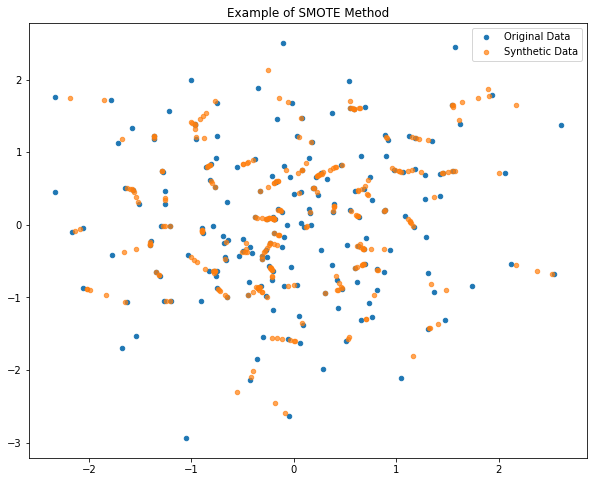

In [152]:
nnn = 300
Z = np.random.randn(200,2)
Zs = smote(Z,n = nnn)
plt.figure(figsize=(10, 8))
plt.scatter(Z[:,0],Z[:,1], s= 20, alpha = 1)
plt.scatter(Zs[:,0],Zs[:,1], s = 20, alpha = .7)
plt.legend(['Original Data', 'Synthetic Data'])
plt.title('Example of SMOTE Method')

# Cross Validation Approaches Imbalanced Case

Results show in ([2](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8492368)) suggest to use this approach in cross-validation in case of imbalanced datasets:
<img src="cross_validation.png">


### In case of imbalanced datasets ([3](http://icaiit.org/proceedings/6th_ICAIIT/1_3Fayzrakhmanov.pdf)) recommend to use the area under of curve of precision-recall. 




[1] Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.

[2] Santos, M. S., Soares, J. P., Abreu, P. H., Araujo, H., & Santos, J. (2018). Cross-Validation for Imbalanced Datasets: Avoiding Overoptimistic and Overfitting Approaches [Research Frontier]. IEEE Computational Intelligence Magazine, 13(4), 59-76.

[3] Fayzrakhmanov, R., Kulikov, A., & Repp, P. (2018, September). The Difference Between Precision-recall and ROC Curves for Evaluating the Performance of Credit Card Fraud Detection Models. In Titel: Proceedings of the 6th International Conference on Applied Innovations in IT. Bibliothek, Hochschule Anhalt.

# Hyperparameter Optimization 

# Logistic Regression

In [13]:
#with SMOTE
nnn = 1000
CC = np.logspace(-1,3, 5)
AUC_C = []
for C in CC:
    model = LogisticRegression(C = C, max_iter = 400, penalty = 'l2',   solver = 'newton-cg') 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    


[0.73194954 0.77075856 0.82797988 0.74510748] , MEAN =  0.7689488636227229 , STD =  0.03682830836324226
[0.72229198 0.76771641 0.82427715 0.74434109] , MEAN =  0.764656657789784 , STD =  0.037985038812036555
[0.71818834 0.76731271 0.82330984 0.74463735] , MEAN =  0.7633620626278443 , STD =  0.038731846581144716
[0.71775913 0.7673129  0.8233222  0.7446354 ] , MEAN =  0.7632574090160498 , STD =  0.03886225239843061
[0.71772929 0.76731288 0.82332212 0.74463536] , MEAN =  0.7632499136834676 , STD =  0.03887096252854592


In [14]:
#without SMOTE
CC = np.logspace(-1,3, 5)
AUC_C_ = []
for C in CC:
    model = LogisticRegression(C = C, max_iter = 400, penalty = 'l2',   solver = 'newton-cg') 
    auc_cros = cross_val_method(X,y, model , nsplit = 4)
    AUC_C_.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    

[0.73502179 0.74017117 0.77099555 0.71629419] , MEAN =  0.7406206770502821 , STD =  0.01965934954408528
[0.73844743 0.73600457 0.75480634 0.71614064] , MEAN =  0.7363497437804019 , STD =  0.013725645766229944
[0.72682566 0.73500703 0.75284106 0.71564254] , MEAN =  0.7325790708972786 , STD =  0.01356826364073209
[0.72531328 0.73490388 0.75275654 0.71562663] , MEAN =  0.7321500815348294 , STD =  0.01371108894708216
[0.72516037 0.73490466 0.75274557 0.71562648] , MEAN =  0.7321092695313213 , STD =  0.013726258277500071


# Plotting of Score of Logistic Regression

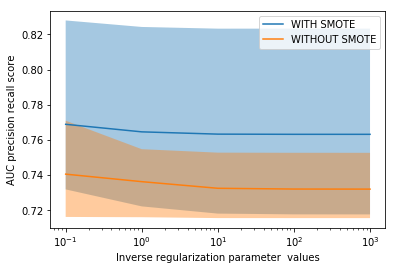

In [15]:
plot_score_C(AUC_C, CC, PLOT = 'SEMILOGX')
plot_score_C(AUC_C_, CC, PLOT = 'SEMILOGX')
plt.xlabel('Inverse regularization parameter  values')
plt.ylabel('AUC precision recall score')
plt.legend(['WITH SMOTE', 'WITHOUT SMOTE'])

### Results showing that score is btetter when SMOTE Method is apllied

# Gradient boosting

In [24]:
#with SMOTE
nnn = 500
CC = np.arange(3,9)
AUC_C = []
for C in CC:
    model = XGBClassifier(  max_depth = C, learning_rate = .2, n_estimators = 100, n_jobs=6 , base_score =  .1) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    


[0.75596538 0.83070185 0.817419   0.77029585] , MEAN =  0.7935955193845325 , STD =  0.031238357563402153
[0.79456646 0.82412076 0.82907992 0.77815542] , MEAN =  0.8064806386449062 , STD =  0.021012894903787094
[0.73141714 0.8211173  0.83765393 0.78234717] , MEAN =  0.7931338857971109 , STD =  0.04089748019768162
[0.78441631 0.81315904 0.83735086 0.79850898] , MEAN =  0.8083587949032102 , STD =  0.019582156588149238
[0.79620521 0.81952576 0.84115453 0.79820134] , MEAN =  0.8137717087516372 , STD =  0.0182616161894758
[0.78844794 0.82455464 0.8352628  0.79550572] , MEAN =  0.8109427740569503 , STD =  0.019500430337600395


In [43]:
#without SMOTE
CC = np.arange(3,9)
AUC_C_ = []
for C in CC:
    model = XGBClassifier(  max_depth = C, learning_rate = .2, n_estimators = 100, n_jobs=4 , base_score =  .1) 
    auc_cros = cross_val_method(X,y, model , nsplit = 4)
    AUC_C_.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    

[0.74193754 0.82844531 0.83576805 0.78747072] , MEAN =  0.7984054065834532 , STD =  0.03743844907861948
[0.80747834 0.82296686 0.83014032 0.77646171] , MEAN =  0.8092618094506567 , STD =  0.020632304520638425
[0.71383146 0.82306366 0.82676935 0.78195842] , MEAN =  0.7864057222903409 , STD =  0.045441798227782756
[0.76820683 0.82758158 0.82634623 0.78220785] , MEAN =  0.8010856248783308 , STD =  0.026351089358853667
[0.77237748 0.81517817 0.84154929 0.78034926] , MEAN =  0.8023635478690991 , STD =  0.027764769600230214


# Plotting Score of Gradient boosting

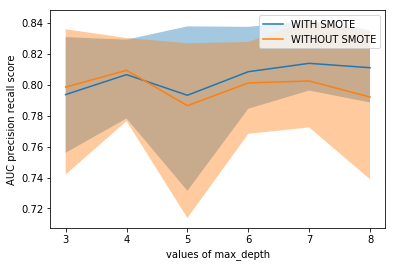

In [25]:
plot_score_C(AUC_C, CC, PLOT = 'o')
plot_score_C(AUC_C_, CC, PLOT = 'o')
plt.xlabel('values of max_depth')
plt.ylabel('AUC precision recall score')
plt.legend(['WITH SMOTE', 'WITHOUT SMOTE'])

## The best performance is with max_depth = 7 and using SMOTE Method


# Tuning learning rate  with max_depth = 7

In [27]:
nnn = 500
CC = np.logspace( np.log10(0.05),  np.log10(0.9), 6)
AUC_C = []
for C in CC:
    model = XGBClassifier(  max_depth = 7, learning_rate = C, n_estimators = 100, n_jobs=6 , base_score =  .1) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )

[0.66086209 0.82367608 0.81739901 0.78559702] , MEAN =  0.7718835512220693 , STD =  0.06570378204474354
[0.67643268 0.81883007 0.83050778 0.79474828] , MEAN =  0.7801297021471656 , STD =  0.06124223346965352
[0.79627743 0.81952996 0.83700407 0.79987581] , MEAN =  0.8131718173752106 , STD =  0.01636006249136045
[0.73289328 0.8219228  0.83410637 0.79421469] , MEAN =  0.7957842845459305 , STD =  0.03908179269370378
[0.74607094 0.81445252 0.84724969 0.78297918] , MEAN =  0.7976880830231698 , STD =  0.037476928708786196
[0.77836162 0.64702471 0.82915417 0.72263666] , MEAN =  0.7442942890293675 , STD =  0.06762434153682234


Text(0, 0.5, 'AUC precision recall score')

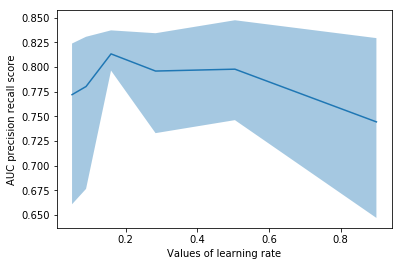

In [28]:
plot_score_C(AUC_C, CC, PLOT = '')
plt.xlabel('Values of learning rate')
plt.ylabel('AUC precision recall score')


## The best performance is with learning rate is between 0.16 and 0.2 approximately


# Tuning base score with learning_rate = 0.16

In [35]:
nnn = 500
CC = np.logspace( np.log10(0.05),  np.log10(0.9), 6)
AUC_C = []
for C in CC:
    model = XGBClassifier(  max_depth = 7, learning_rate = 0.16, n_estimators = 100, n_jobs= 6 , base_score =  C) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )

[0.75788773 0.81914589 0.8303415  0.80575652] , MEAN =  0.8032829066588294 , STD =  0.027616309796029956
[0.76512845 0.82062375 0.83392883 0.79782753] , MEAN =  0.8043771429562057 , STD =  0.026079744255163864
[0.74815648 0.81842298 0.83893397 0.80057525] , MEAN =  0.8015221710425271 , STD =  0.03366776636838922
[0.78897899 0.82417139 0.83640427 0.79723156] , MEAN =  0.8116965505036605 , STD =  0.019309431739295082
[0.75068514 0.82144131 0.83163588 0.78919794] , MEAN =  0.7982400677856509 , STD =  0.03161015995242131
[0.7773558  0.81519655 0.82720108 0.78687212] , MEAN =  0.8016563879062542 , STD =  0.02027905349429701


Text(0, 0.5, 'AUC precision recall score')

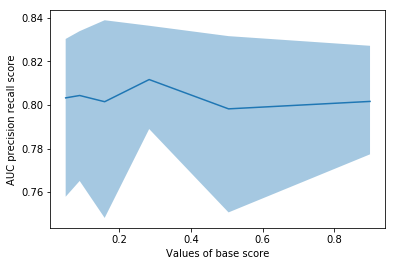

In [36]:
plot_score_C(AUC_C, CC, PLOT = 'o')
plt.xlabel('Values of base score')
plt.ylabel('AUC precision recall score')


## The best performance is with learning rate is between 0.25 and 0.3 approximately


# Tuning Number of resamplong with base_score = 0.28

In [41]:
NN = (np.logspace( np.log10(10),  np.log10(2000), 8)).astype(int)  
AUC_C = []
for nnn in NN:
    model = XGBClassifier(  max_depth = 7, learning_rate = 0.16, n_estimators = 100, n_jobs= 6, base_score =  0.28) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )

[0.74961022 0.82722558 0.83920531 0.78557769] , MEAN =  0.800404699098589 , STD =  0.03544279617574259
[0.77687942 0.81759297 0.83434234 0.78143603] , MEAN =  0.8025626917844741 , STD =  0.024196184154298243
[0.72781864 0.81775612 0.84357383 0.78455833] , MEAN =  0.7934267292526612 , STD =  0.04327158792832796
[0.73163105 0.81549596 0.83676843 0.79467136] , MEAN =  0.7946417007582657 , STD =  0.03930618143240293
[0.76259266 0.81888681 0.82615482 0.79125987] , MEAN =  0.7997235380328316 , STD =  0.025080766500825812
[0.78341907 0.81771075 0.83979668 0.78907239] , MEAN =  0.8074997242705808 , STD =  0.02273105302045465
[0.71745509 0.82412936 0.84048586 0.79458911] , MEAN =  0.7941648548857185 , STD =  0.04724424598757743
[0.74352009 0.81677074 0.83604063 0.79063314] , MEAN =  0.7967411494439888 , STD =  0.03469662368452702


Text(0, 0.5, 'AUC precision recall score')

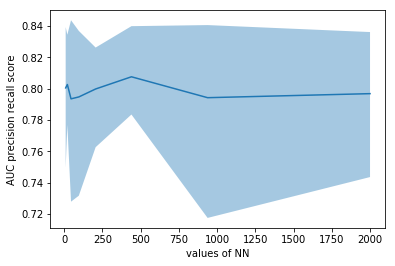

In [42]:
plot_score_C(AUC_C, NN, PLOT = 'o')
plt.xlabel('values of NN')
plt.ylabel('AUC precision recall score')

## The last plot suggests that the best performance is when increasing the number of resampling between 440 and 500, because the variance of the score is lower, for other values the variance increases.

## Other hyperameters for the best performance in 'XGBClassifier' are: max_depth = 7,  learning_rate = 0.16,  and  base_score = 0.28 with area under of curve precision recall as metric

# Random Search of Hyperparameters
Results in ( [4](http://www.jmlr.org/papers/v13/bergstra12a.html) ) show that random search experiments are more efficient than grid experiments for hyperparameters on several machine learning techniques. }


We search the best hyperparameters for "learning_rate" and "base_score" in $XGBClassifier$ fixing "max_depth" =  7 and  adding 450 synthetic data.

[4] Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. Journal of Machine Learning Research, 13(Feb), 281-305.


# SMOTE Method

In [78]:
nnn = 450
CC = [np.random.rand(15)*.5 , np.random.rand(15)*.5] 
CC = np.array(CC).T
AUC_C = []
for C in CC:
    model = XGBClassifier(  max_depth = 7, learning_rate = C[0], n_estimators = 100, n_jobs=8 , base_score =  C[1]) 
    auc_cros = cross_val_method_SMOTE(X,y, model , nsplit = 4, nn = nnn)
    AUC_C.append(auc_cros )
    print('learning_rate = ', C[0], ', base_score = ', C[1])
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )



learning_rate =  0.2087431873980059 , base_score =  0.12420673254148551
[0.78807728 0.81486556 0.84044808 0.79280576] , MEAN =  0.8090491722961555 , STD =  0.02075686939513846
learning_rate =  0.06564466423662801 , base_score =  0.2529331919126542
[0.68976606 0.82006211 0.82124868 0.77568303] , MEAN =  0.7766899715082904 , STD =  0.05344015615595446
learning_rate =  0.302058902010441 , base_score =  0.1551904129899057
[0.74787261 0.81722926 0.83729245 0.78166607] , MEAN =  0.7960150979099325 , STD =  0.034195958896668925
learning_rate =  0.19140402957892705 , base_score =  0.18651743194037373
[0.76080931 0.82345837 0.83862939 0.7981143 ] , MEAN =  0.8052528422958953 , STD =  0.029460231580950708
learning_rate =  0.447692942144105 , base_score =  0.26248522112713213
[0.78093828 0.81695693 0.83911416 0.78210921] , MEAN =  0.8047796431844619 , STD =  0.024543350494840514
learning_rate =  0.48389733589925094 , base_score =  0.37529751146449375
[0.79446905 0.82042613 0.82845833 0.78836185] 

max. score =  0.8153982762880245


Text(0.5, 1.0, 'SMOTE Method')

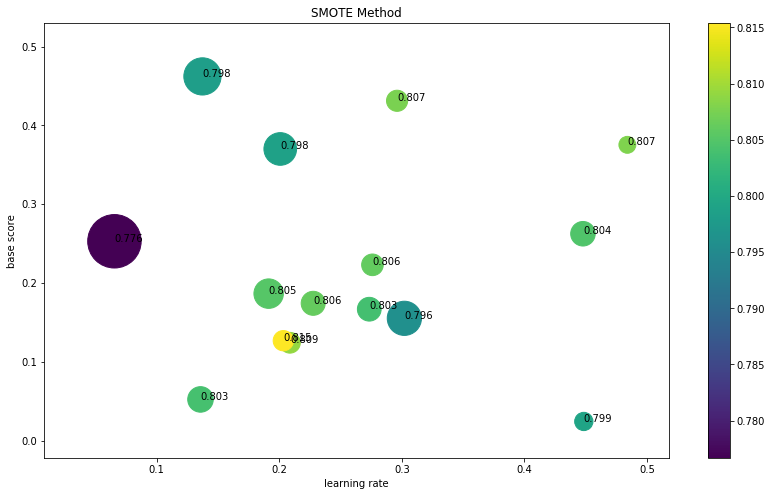

In [155]:
Cm = np.mean(AUC_C, axis = 1)
Cstd = np.std(AUC_C, axis = 1)
Cmin = np.min(AUC_C, axis = 1)
Cmax = np.max(AUC_C, axis = 1)
print('max. score = ' , Cm.max())
plt.figure(figsize = (14,8))
plt.scatter(CC[:,0], CC[:,1],s = (Cstd*1000)**2 ,  c = Cm , cmap = 'viridis') , plt.colorbar() 
for i, txt in enumerate(Cm):
    plt.annotate(str(txt)[0:5],  ( CC[i,0], CC[i,1]) )

plt.xlabel('learning rate')
plt.ylabel('base score')
plt.title('SMOTE Method')

# Without SMOTE

In [93]:
AUC_C_ = []
for C in CC:
    model = XGBClassifier(  max_depth = 7, learning_rate =  C[0], n_estimators = 100, n_jobs=8 , base_score =  C[1]) 
    auc_cros = cross_val_method(X,y, model , nsplit = 4)
    AUC_C_.append(auc_cros )
    print('learning_rate = ', C[0], ', base_score = ', C[1])
    print(auc_cros , ', MEAN = ', auc_cros.mean(), ', STD = ' , auc_cros.std() )
    

learning_rate =  0.2087431873980059 , base_score =  0.12420673254148551
[0.79017914 0.82043579 0.84174647 0.78840733] , MEAN =  0.8101921809763225 , STD =  0.022224460171436294
learning_rate =  0.06564466423662801 , base_score =  0.2529331919126542
[0.69539519 0.81625018 0.81654533 0.76303185] , MEAN =  0.7728056396467917 , STD =  0.04972045198223952
learning_rate =  0.302058902010441 , base_score =  0.1551904129899057
[0.77528673 0.80803869 0.83634927 0.79242668] , MEAN =  0.803025343209182 , STD =  0.022457625700329293
learning_rate =  0.19140402957892705 , base_score =  0.18651743194037373
[0.78160255 0.82279317 0.82716371 0.78127692] , MEAN =  0.8032090904065872 , STD =  0.021824427655824558
learning_rate =  0.447692942144105 , base_score =  0.26248522112713213
[0.77257465 0.81454745 0.84128931 0.78181639] , MEAN =  0.8025569507061932 , STD =  0.027262963726807657
learning_rate =  0.48389733589925094 , base_score =  0.37529751146449375
[0.79322713 0.8112933  0.82590355 0.78659404] 

max. score =  0.8132504442296369


Text(0.5, 1.0, 'Without SMOTE')

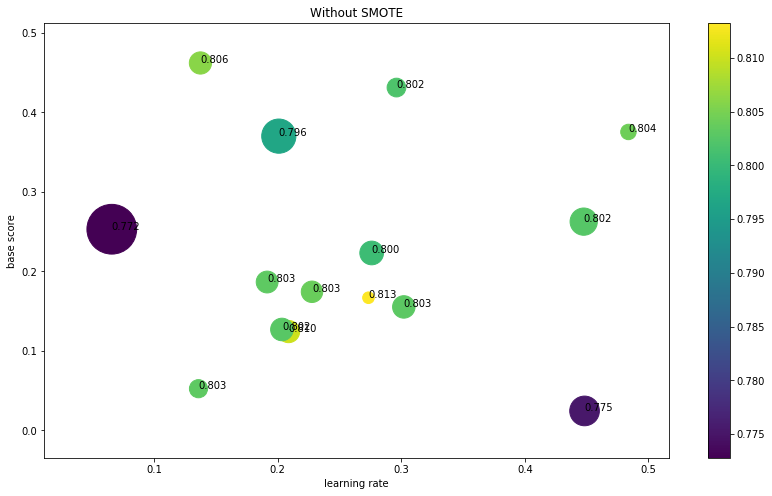

In [156]:
Cm_= np.mean(AUC_C_, axis = 1)
Cstd_ = np.std(AUC_C_, axis = 1)
Cmin_ = np.min(AUC_C_, axis = 1)
Cmax_ = np.max(AUC_C_, axis = 1)
print('max. score = ' , Cm_.max())
plt.figure(figsize = (14,8))
plt.scatter(CC[:,0], CC[:,1],s = (Cstd_*1000)**2 ,  c = Cm_ , cmap = 'viridis') , plt.colorbar() 
for i, txt in enumerate(Cm_):
    plt.annotate(str(txt)[0:5],  ( CC[i,0], CC[i,1]) )

plt.xlabel('learning rate')
plt.ylabel('base score')
plt.title('Without SMOTE')

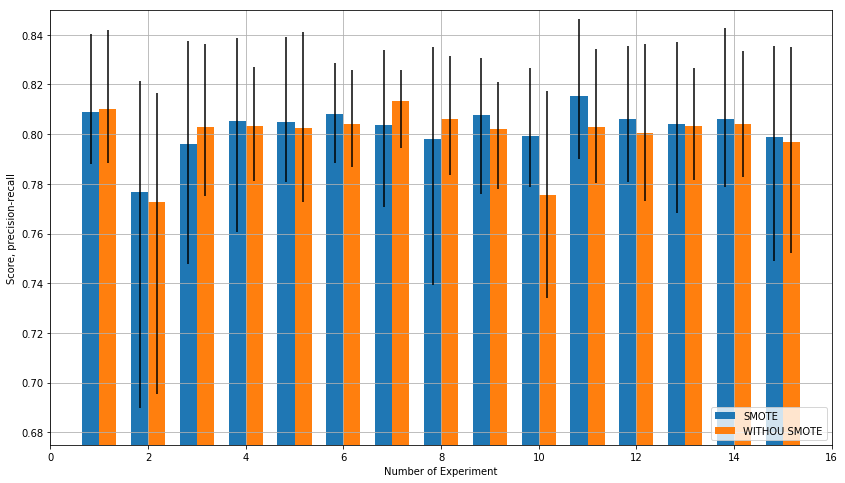

In [160]:
ind = np.arange(len(Cm)) +1  # the x locations for the experiments
width = 0.35  # the width of the bars

fig, ax = plt.subplots( figsize= (14,8))
rects1 = ax.bar(ind - width/2, Cm, width, yerr= ([Cm - Cmin,  Cmax-Cm]), 
                label='SMOTE')
rects2 = ax.bar(ind + width/2, Cm_, width, yerr= ([Cm_ - Cmin_,  Cmax_-Cm_]),
                label='WITHOU SMOTE')
plt.axis([ 0, 16, .675 , .85])
plt.legend(loc = 4)
plt.xlabel('Number of Experiment')
plt.ylabel('Score, precision-recall')
plt.grid()



## The last plot shows SMOTE Method in the majority of experiments has better performance, because the means and the maximum values of the score in the cross-validation are greater than not-resampling experiments.
## The best parameter are learning_rate =  $0.2034$ and base_score =  $0.1268$